# **Import Statements**

In [ ]:
import opensim as osim
import matplotlib.pyplot as plt
import numpy as np
from Bicep import Bicep_Curl
osim.GetVersionAndDate()


%load_ext autoreload
%autoreload 2

# **Model Loading**

In [3]:
# Load the model.
arm26 = osim.Model('OpenSIM_utils\\Arm26\\arm26.osim')

# Print metadata.
print("Name of the model:", arm26.getName())
print("Author:", arm26.get_credits())
print("Publications:", arm26.get_publications())
print("Length Unit:", arm26.get_length_units())
print("Force Unit:", arm26.get_force_units())
print("Gravity:", arm26.get_gravity())

# Use the TableProcessor to read the motion file.
tableTime = osim.TimeSeriesTable('OpenSIM_utils\\Arm26\\OutputReference\\InverseKinematics\\arm26_InverseKinematics.mot')
print(tableTime.getColumnLabels())

#Named variables
r_shoulder_elev = tableTime.getDependentColumn('r_shoulder_elev').to_numpy()
r_elbow_flex = tableTime.getDependentColumn('r_elbow_flex').to_numpy()
t = tableTime.getIndependentColumn()


Name of the model: arm26
Author: The OpenSim Development Team (Reinbolt, J; Seth, A; Habib, A; Hamner, S) adapted from a model originally created by Kate Holzbaur (11/22/04) License: Creative Commons (CCBY 3.0). You are free to distribute, remix, tweak, and build upon this work, even commercially, as long as you credit us for the original creation. http://creativecommons.org/licenses/by/3.0/
Publications: Holzbaur, K.R.S., Murray, W.M., Delp, S.L. A Model of the Upper Extremity for Simulating Musculoskeletal Surgery and Analyzing Neuromuscular Control. Annals of Biomedical Engineering, vol 33, pp 829–840, 2005
Length Unit: meters
Force Unit: N
Gravity: ~[0,-9.8066,0]
('r_shoulder_elev', 'r_elbow_flex')


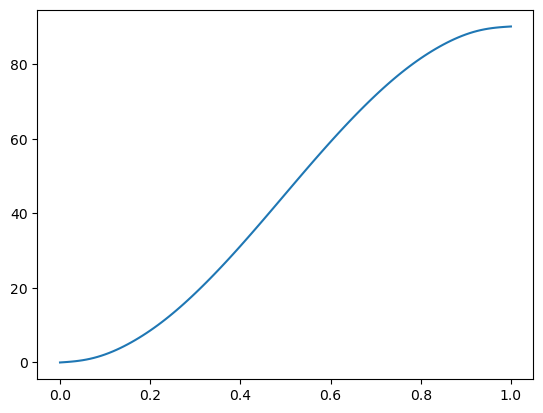

In [4]:
#plt.plot(t, r_shoulder_elev)
plt.plot(t, r_elbow_flex)
plt.show()


# **Implmentation of Static Optimization**

In [12]:
step_per_second = 300
curl_time = 2
bicep = Bicep_Curl(curl_time = curl_time, sps = step_per_second)

# Run Simulation Under zero external force
activation = []
for i in range(int(curl_time*step_per_second)):
    activation.append(bicep.step_simulation(i, 0.0))

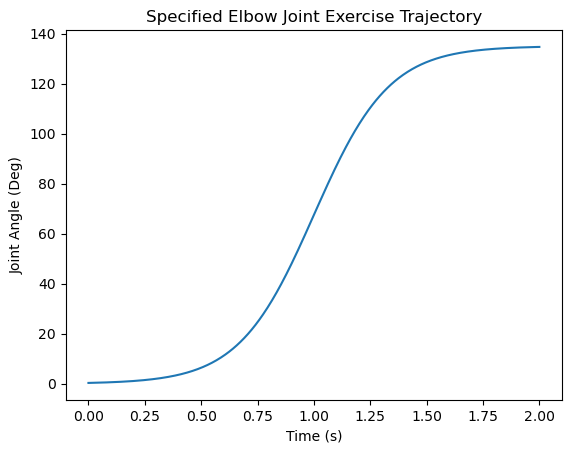

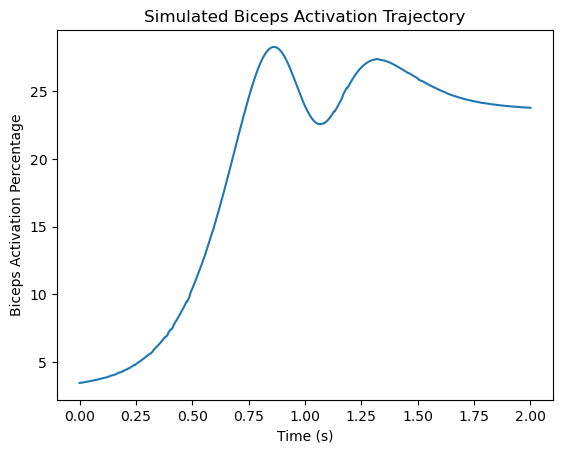

In [15]:
#Plotting
t, elbow_traj = bicep._traj()
plt.plot(t, np.rad2deg(elbow_traj)) 
plt.xlabel("Time (s)")
plt.ylabel("Joint Angle (Deg)")
plt.title("Specified Elbow Joint Exercise Trajectory")
plt.show()

activation = np.asarray(activation)*100
plt.plot(t, activation)
plt.xlabel("Time (s)")
plt.ylabel("Biceps Activation Percentage")
plt.title("Simulated Biceps Activation Trajectory")
plt.show()